<a href="https://colab.research.google.com/github/sanskruti-1234/ML/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
!pip install yfinance
!pip install tensorflow
!pip install keras
!pip install matplotlib
!pip install sklearn
!pip install pandas
!pip install numpy

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [6]:
# Configuration
TICKER = 'AAPL'
START_DATE = '2020-01-01'
END_DATE = datetime.now().strftime('%Y-%m-%d')
SEQ_LENGTH = 30  # Number of days to look back
TEST_SIZE = 0.2  # Percentage of data for testing

def download_data(ticker, start_date, end_date):
    """Download stock data from Yahoo Finance"""
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

def calculate_technical_indicators(df):
    """Add basic technical indicators to the dataframe"""
    # Simple Moving Averages
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    # Relative Strength Index (RSI)
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df # Added return statement to return modified df

# Download data and calculate indicators
df = download_data(TICKER, START_DATE, END_DATE) # Call download_data to get the dataframe
df = calculate_technical_indicators(df) # Call calculate_technical_indicators to add indicators

# Moving Average Convergence Divergence (MACD)
exp12 = df['Close'].ewm(span=12, adjust=False).mean()
exp26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp12 - exp26
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [7]:
# Bollinger Bands
rolling_mean = df['Close'].rolling(window=20).mean()
rolling_std = df['Close'].rolling(window=20).std()
df['Upper_Band'] = rolling_mean + (2 * rolling_std)
df['Lower_Band'] = rolling_mean - (2 * rolling_std)

In [8]:
# Drop NaN values
df.dropna(inplace=True)
#return df # This line was causing a syntax error outside of a function definition.  If it needs to be in a function, please provide the function definition

In [9]:
def prepare_data(df, seq_length):
    """Prepare data for LSTM model"""
    # Select features
    features = ['Close', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'Upper_Band', 'Lower_Band']
    data = df[features].values

    # Create target (1 if next day's price is higher, 0 otherwise)
    target = (df['Close'].shift(-1) > df['Close']).astype(int).values
    target = target[:-1]  # Remove last row which has NaN
    data = data[:-1]      # Align with target

    # Normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Create sequences
    X, y = [], []
    for i in range(len(scaled_data) - seq_length):
        X.append(scaled_data[i:i+seq_length])
        y.append(target[i+seq_length-1])  # Changed to use correct target index

    return np.array(X), np.array(y), scaler



In [10]:
def build_lstm_model(input_shape):
    """Build a simple LSTM model"""
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model # Moved model.compile into the function to be called after the model is created


In [14]:
def evaluate_model(model, X_test, y_test):
    """Evaluate model performance"""
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.2%}")
    return y_pred, accuracy # Return y_pred and accuracy

In [15]:
# Prepare data
X, y, scaler = prepare_data(df, SEQ_LENGTH)

In [16]:
# Split data into training and testing sets
split_index = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [17]:
# Build and train the model
model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
model.fit(X_train, y_train, epochs=50, batch_size=32) # Adjust epochs and batch_size as nee

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5023 - loss: 0.6969
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5195 - loss: 0.6914
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5364 - loss: 0.6906
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5062 - loss: 0.6906
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5323 - loss: 0.6931
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5211 - loss: 0.6937
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5516 - loss: 0.6887
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4843 - loss: 0.6924
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5252 - loss: 0.6903
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5475 - loss: 0.6894
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5106 - loss: 0.6915
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy:

In [18]:
# Evaluate the model and get predictions
y_pred, accuracy = evaluate_model(model, X_test, y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Test Accuracy: 42.46%


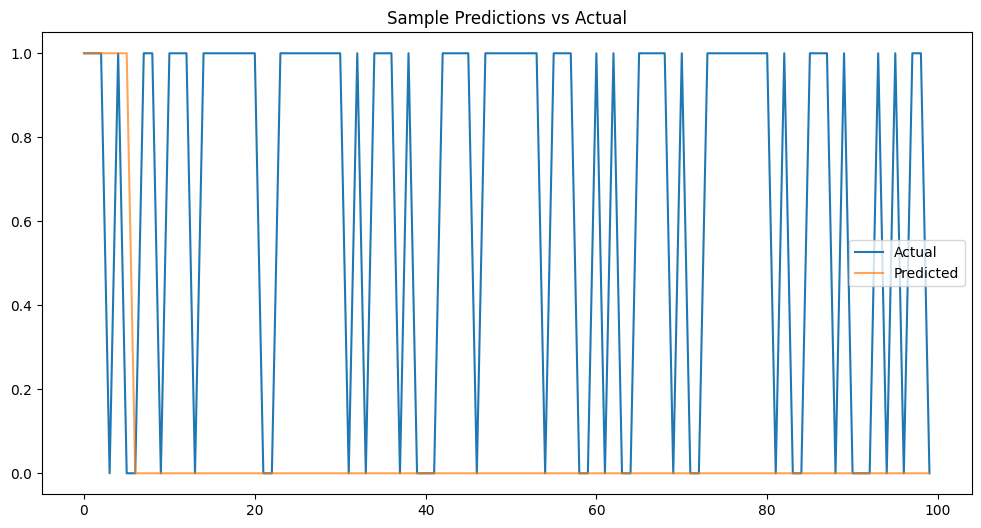

In [19]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted', alpha=0.7) # Using y_pred returned from evaluate_model
plt.title('Sample Predictions vs Actual')
plt.legend()
plt.show()

In [31]:
def backtest_strategy(df, predictions, test_start_idx):
    """Backtest a simple trading strategy"""
    # Create a copy of the dataframe for the test period
    test_df = df.iloc[test_start_idx + SEQ_LENGTH:-1].copy()
    test_df = test_df.iloc[:len(predictions)]  # Ensure same length as predictions

    test_df['Prediction'] = predictions

    # Simple strategy: Buy when prediction > 0.5, Sell when < 0.5
    test_df['Position'] = 0
    test_df.loc[test_df['Prediction'] > 0.5, 'Position'] = 1
    test_df.loc[test_df['Prediction'] < 0.5, 'Position'] = -1

    # Calculate daily returns
    test_df['Market_Return'] = test_df['Close'].pct_change()
    test_df['Strategy_Return'] = test_df['Position'].shift(1) * test_df['Market_Return']

     # Calculate cumulative returns
    test_df['Cumulative_Market'] = (1 + test_df['Market_Return']).cumprod()
    test_df['Cumulative_Strategy'] = (1 + test_df['Strategy_Return']).cumprod()

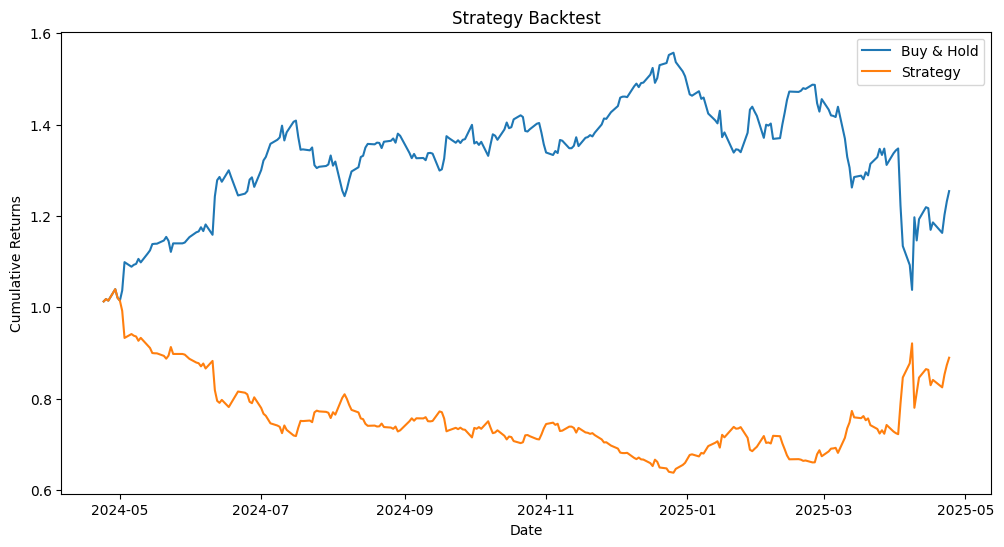

In [34]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_df['Cumulative_Market'], label='Buy & Hold')
plt.plot(test_df['Cumulative_Strategy'], label='Strategy')
plt.title('Strategy Backtest')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

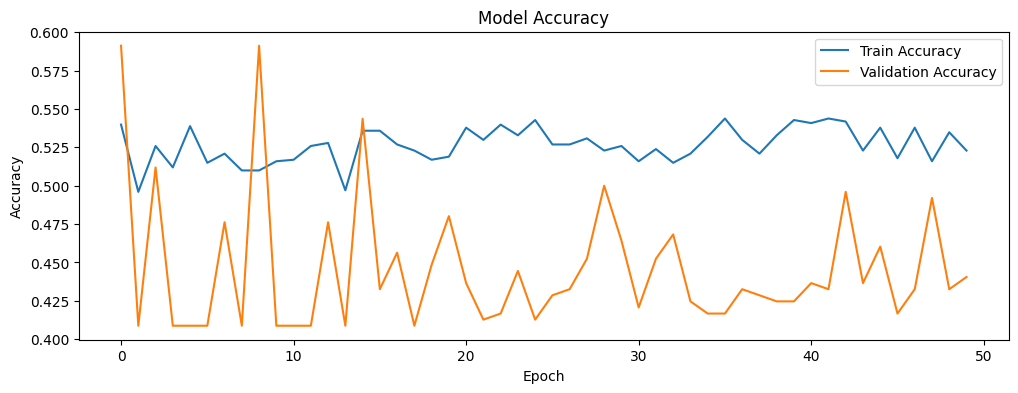

In [54]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed

Calculating technical indicators...
Preparing data for model...
Building model...
Training model...
Epoch 1/50



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4794 - loss: 0.6966 - val_accuracy: 0.5159 - val_loss: 0.6944
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5370 - loss: 0.6958 - val_accuracy: 0.4087 - val_loss: 0.7067
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4966 - loss: 0.6938 - val_accuracy: 0.4087 - val_loss: 0.7036
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5208 - loss: 0.6930 - val_accuracy: 0.5675 - val_loss: 0.6894
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5098 - loss: 0.6922 - val_accuracy: 0.5119 - val_loss: 0.6937
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5242 - loss: 0.6908 - val_accuracy: 0.4087 - val_loss: 0.7029
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5188 - loss: 0.6933 - val_accuracy: 0.4325 - val_loss: 0.7037
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5370 - loss: 0.6898 - val_accuracy: 0.4087 - val_loss: 0.

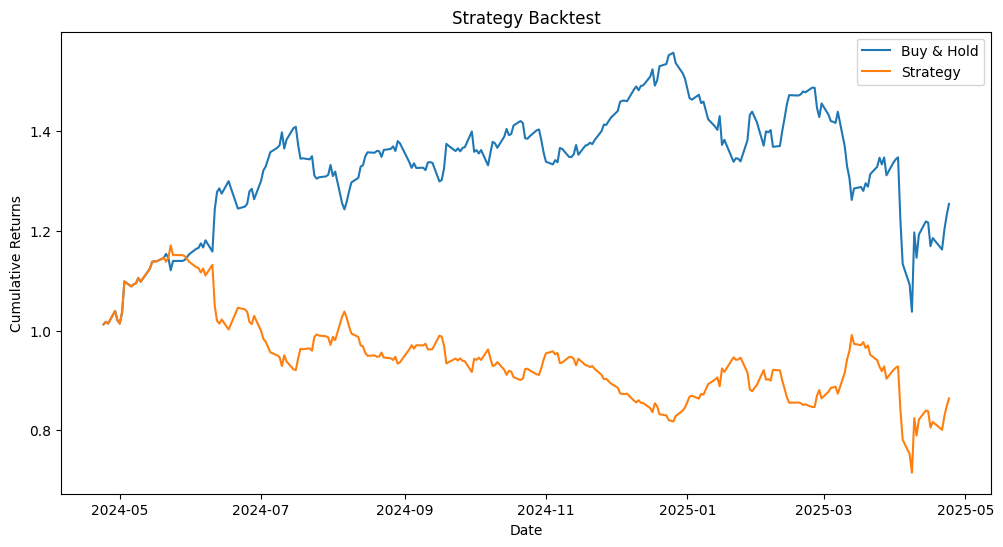

In [57]:
def main():
    # Step 1: Download and prepare data
    print("Downloading data...")
    data = download_data(TICKER, START_DATE, END_DATE)

    print("Calculating technical indicators...")
    data = calculate_technical_indicators(data)

    # Calculate and add MACD, Signal Line, and Bollinger Bands
    exp12 = data['Close'].ewm(span=12, adjust=False).mean()
    exp26 = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = exp12 - exp26
    data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

    rolling_mean = data['Close'].rolling(window=20).mean()
    rolling_std = data['Close'].rolling(window=20).std()
    data['Upper_Band'] = rolling_mean + (2 * rolling_std)
    data['Lower_Band'] = rolling_mean - (2 * rolling_std)

    # Drop NaN values after calculating all indicators
    data.dropna(inplace=True)

    print("Preparing data for model...")
    X, y, scaler = prepare_data(data, SEQ_LENGTH)

    # Split into train and test sets
    split_idx = int(len(X) * (1 - TEST_SIZE))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Step 2: Build and train LSTM model
    print("Building model...")
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

    print("Training model...")
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1)

    # Step 3: Evaluate model
    print("Evaluating model...")
    _, accuracy = evaluate_model(model, X_test, y_test) #  Use _ to discard y_pred

    # Step 4: Backtest strategy
    print("Backtesting strategy...")
    predictions = (model.predict(X_test) > 0.5).astype(int)
    backtest_strategy(data, predictions, split_idx) # Call backtest_strategy here

# Call main function to start the process
main()